## Extracting Monthly Temperature Data from Array

### Author: Ryan Gan
### Date: 2018-05-28

Extracting gridded temperature values to North American region. First attempt with Python. Dates appear to be every from 1980 to 2018.

In [1]:
# import dataset from netCDF as nc_open; array storage system
import netCDF4 as nc
# import dataset
from netCDF4 import Dataset 
# interpolate griddate
from scipy import interpolate
# import numpy as np; for working with array data
import numpy as np
# import pandas as pd; working with data.frames
import pandas as pd
# Matplotlib for additional customization
from matplotlib import pyplot as plt 
%matplotlib inline
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Open connection to monthly temperature netCDF file.

In [2]:
# open temp nc
temp_nc = Dataset("../data/nc/air.mon.mean.nc")

Print out summary of temperature NetCDF file. It looks like x/lon = 144, y/lat = 73, and 843 months.

In [3]:
print(temp_nc)
# print out details of each variable
for v in temp_nc.variables:
    print(temp_nc.variables[v])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc
created 95/03/13 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean air.sig995 from the NCEP Reanalysis
    References: http://www.esrl.noaa.gov/psd/dat

### Extracting Grid Locations of Temperature Grid

I'm going to see if I can output the grid locations and plot it.

In [4]:
# extract latitude
lat = temp_nc.variables['lat'][:]
# extract longitude
lon = temp_nc.variables['lon'][:]
# extract time
time = temp_nc.variables['time'][:]
# 1st temperature values
temp = temp_nc.variables['air'][1,:,:]
# check dimension of shape
np.shape(temp)

(73, 144)

Print out min, mean, max of temperature vector.

In [5]:
print(np.min(temp), np.mean(temp), np.max(temp))

-44.23103 2.1757681 35.399654


Using Seaborn to print out a heatmap the first matrix of temperature. I notice the outline of the continents based on the temperature. You can see the Rocky mountains and the Andes mountains running down the left side of the Americas. The Poles are much colder. The Australian outback looks hot too.

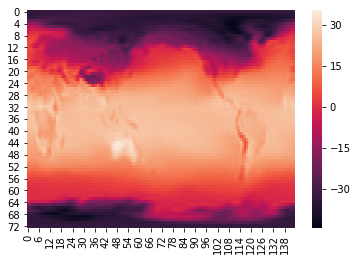

In [6]:
sns.heatmap(temp)

I want to subset the array to the spatial extent of the continental United States.  The longitude bounds should be  -124.848974 to -66.885444. I will need to add 180 degrees to these degrees west to match the convert from degrees east of the nc file. The latitude bounds should be 24.396308 to 49.384358.

In [37]:
# lat and lon bounds
latbounds = [24, 50]
# lon bounds need to be converted from easterling to westerling to get US
lonbounds = [-125 + 360, -66 + 360]

# latitude lower and upper bounds
lat_ui = np.argmin(np.abs(lat - latbounds[0]))
lat_li = np.argmin(np.abs(lat - latbounds[1]))

# longitude lower and upper boudns
lon_li = np.argmin(np.abs(lon - lonbounds[0]))
lon_ui = np.argmin(np.abs(lon - lonbounds[1]))
# print index
print(lat_li, lat_ui, lon_li, lon_ui)

16 26 94 118


Subset latitude and longitude grid points.

In [38]:
# subset us lon
lon_us = lon[lon_li:lon_ui]-360
# subset us lat
lat_us = lat[lat_li:lat_ui]
# print dimensions
print(np.min(lon_us), np.max(lon_us), np.min(lat_us), np.max(lat_us))

-125.0 -67.5 27.5 50.0


Print points over US.

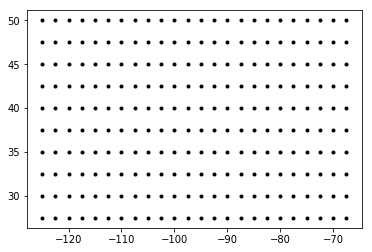

In [39]:
# extract lonlat grid
lons, lats = np.meshgrid(lon_us, lat_us)
# plot
plt.plot(lons, lats, marker='.', color='k', linestyle='none')
plt.show()

In [40]:
# subset temp to us
temp_us = temp_nc.variables['air'][1, lat_li:lat_ui, lon_li:lon_ui]
np.shape(temp_us)

(10, 24)

Plot heatmap of US temperature to make sure subset looks right.

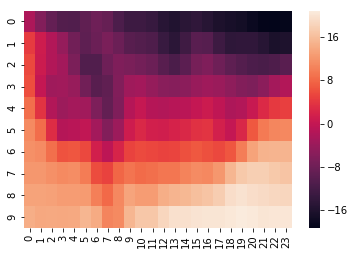

In [41]:
sns.heatmap(temp_us)

### Binary Interpolation of Temperature to Finer Grid Resolution

Using interpolation to estimate temperature to a finer grid. Testing out with one array first. Creating a 1x1 degree grid.

In [42]:
# custom grids for every degree
# vectors
grid_lat = np.arange(24, 50.0, 1)
grid_lon = np.arange(-125.0, -66, 1)
# mesh grid array
glons, glats = np.meshgrid(grid_lon, grid_lat)

Plotting new grid to check shape.

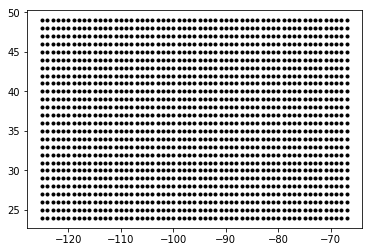

In [43]:
# plot new grid
plt.plot(glons, glats, marker='.', color='k', linestyle='none')
plt.show()

Set up interpoloation spline using RectBivariateSpline, which is faster than interp2D if it's a regular grid (which it is). Lats and Lons need to be sorted and the dimensions need to match shape of value array (ndvi).

In [44]:
# set up interp spline, coordinates need to be 1D arrays, and match the shape of the 3d array.
interp_spline = interpolate.RectBivariateSpline(sorted(lat_us), lon_us, temp_us)

Interpolate the temp values from the find grid to coarse grid.

In [45]:
# interpolate to new grid
temp_fine = interp_spline(grid_lat, grid_lon)

Check shape of new coarse grid.

In [46]:
# shape of coarse grid
np.shape(temp_fine)

(26, 59)

Plot the new heatmap of the reshaped grid.

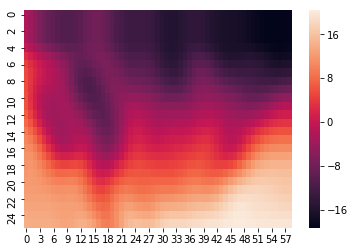

In [47]:
sns.heatmap(temp_fine)

Create custom function to interpolate over each date of array.

In [48]:
# extract full monthly grid
temp_us_full = temp_nc.variables['air'][:, lat_li:lat_ui, lon_li:lon_ui]

In [49]:
# check shape
np.shape(temp_us_full)

(843, 10, 24)

In [50]:
# create empty numpy array of 843 days and 23 lon by 55 lat 
temp_fine = np.zeros((843, 26, 59))

# interpolate for each month to new grid
for i in range(843):
    # extract temp element
    temp_mon = temp_us_full[i]
    # create interpolate 
    interp_spline = interpolate.RectBivariateSpline(sorted(lat_us), lon_us, temp_mon)
    # interpolate to new grid
    temp_fine[i] = interp_spline(grid_lat, grid_lon)

In [51]:
# check shape of empty grid
np.shape(temp_fine)

(843, 26, 59)

#### Flatten Regrided Array

In [52]:
# coordinates to a 2 dimension array
us_grid = np.array(np.meshgrid(grid_lon, grid_lat)).reshape(2, -1).T
# check dimensions
np.shape(us_grid)

(1534, 2)

In [55]:
# extract temp grid as a 843 by n matrix
us_temp = temp_fine.reshape(843,1534).T #.T is for transpose
# check shape
np.shape(us_temp)

(1534, 843)

Creating data frame of us temp and coordinates using pandas. I'm going to create a sequential numeric vector to indicate grid cell id.

In [70]:
np.shape(glons)

(26, 59)

In [73]:
# create grid id array
grid_id = np.arange(1, 1535,1)
grid_id_array = np.reshape(grid_id, (26,59))

In [77]:
grid_id_flat = grid_id_array.flatten()

In [79]:
np.shape(grid_id_flat)

(1534,)

In [80]:
grid_id_flat[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [81]:
# create grid id 1 to 1534 and save as type string
grid_id = pd.DataFrame(grid_id_flat).astype('str')
grid_id.columns = ['grid_id'] 
# head and tail
print(grid_id.head(), grid_id.tail())

  grid_id
0       1
1       2
2       3
3       4
4       5      grid_id
1529    1530
1530    1531
1531    1532
1532    1533
1533    1534


Binding/concatenating grid id variable with lon and lat coordinates.

In [82]:
# create grid dataframe from coordinate array
grid_df = pd.DataFrame(data = us_grid)
# name columns
grid_df.columns = ['glon', 'glat']
# concat dataframes
grid_df = pd.concat([grid_id, grid_df], axis=1)
# view first rows
grid_df.head()
# write grid coords
#grid_df.to_csv('./data/temp_grid.csv')

,grid_id,glon,glat
0,1,-125.0,24.0
1,2,-124.0,24.0
2,3,-123.0,24.0
3,4,-122.0,24.0
4,5,-121.0,24.0


In [83]:
# check tail
grid_df.tail()

,grid_id,glon,glat
1529,1530,-71.0,49.0
1530,1531,-70.0,49.0
1531,1532,-69.0,49.0
1532,1533,-68.0,49.0
1533,1534,-67.0,49.0


Assigning year and month as column header for temperature values.

In [84]:
from datetime import datetime
# extract date times from nc file; define units
date = nc.num2date(time, 'hours since 1800-01-01 00:00:0.0')
# ts
ts = pd.Series(date, index = date)
# view first couple observations
ts.head()

1948-01-01   1948-01-01
1948-02-01   1948-02-01
1948-03-01   1948-03-01
1948-04-01   1948-04-01
1948-05-01   1948-05-01
dtype: datetime64[ns]

Convert temperature array to dataframe.

In [85]:
# array to dataframe
temp_df = pd.DataFrame(data = us_temp)
# add name
temp_df.columns = ts.dt.date

Bind temperature values to coordinate and grid id and then melt/gather columns to row.

In [86]:
# concat grid id and temp
temp_wide_df = pd.concat([grid_df, temp_df], axis = 1)
temp_wide_df.head()

,grid_id,glon,glat,1948-01-01,1948-02-01,1948-03-01,1948-04-01,1948-05-01,1948-06-01,1948-07-01,...,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01
0,1,-125.0,24.0,-0.177099,-2.077586,-0.239029,2.191003,7.611294,13.192339,12.858393,...,10.256660,11.999190,14.542734,12.675834,7.008055,2.904991,0.984665,2.214507,-0.944651,1.861282
1,2,-124.0,24.0,-1.932245,-3.795196,-1.796666,1.195695,7.367382,13.487704,12.898592,...,10.312289,12.313272,15.073903,12.335163,5.715469,1.537424,-1.071836,0.948643,-2.802670,0.641493
2,3,-123.0,24.0,-3.540723,-5.320706,-3.199798,0.287343,7.055917,13.506609,12.850537,...,10.344660,12.867927,15.699352,12.060615,4.622518,0.376322,-2.861392,-0.128779,-4.354234,-0.400468
3,4,-122.0,24.0,-4.988208,-6.661686,-4.465336,-0.522655,6.702666,13.301166,12.724995,...,10.354967,13.583203,16.331797,11.831486,3.734005,-0.599246,-4.400763,-1.043431,-5.653933,-1.275197
4,5,-121.0,24.0,-6.260375,-7.825707,-5.610193,-1.222901,6.333396,12.923484,12.532735,...,10.344403,14.379145,16.883956,11.627070,3.054733,-1.410213,-5.706706,-1.820983,-6.756352,-1.993287


In [88]:
# wide to long
temp_long_df = pd.melt(temp_wide_df, id_vars = ['grid_id', 'glon', 'glat'],
                      var_name = "date", value_name = "temp_c")
# view head of final row-wise dataset
temp_long_df.head()

,grid_id,glon,glat,date,temp_c
0,1,-125.0,24.0,1948-01-01,-0.177099
1,2,-124.0,24.0,1948-01-01,-1.932245
2,3,-123.0,24.0,1948-01-01,-3.540723
3,4,-122.0,24.0,1948-01-01,-4.988208
4,5,-121.0,24.0,1948-01-01,-6.260375


In [90]:
temp_long_df.tail()

,grid_id,glon,glat,date,temp_c
1293157,1530,-71.0,49.0,2018-03-01,19.416759
1293158,1531,-70.0,49.0,2018-03-01,19.509173
1293159,1532,-69.0,49.0,2018-03-01,19.645989
1293160,1533,-68.0,49.0,2018-03-01,19.812518
1293161,1534,-67.0,49.0,2018-03-01,19.902334


In [91]:
# describe dataframe
temp_long_df.describe()

,glon,glat,temp_c
count,1.293162e+06,1.293162e+06,1.293162e+06
mean,-9.600000e+01,3.650000e+01,1.025466e+01
std,1.702939e+01,7.500003e+00,1.112542e+01
min,-1.250000e+02,2.400000e+01,-2.723930e+01
25%,-1.110000e+02,3.000000e+01,2.299681e+00
50%,-9.600000e+01,3.650000e+01,1.241908e+01
75%,-8.100000e+01,4.300000e+01,1.873542e+01
max,-6.700000e+01,4.900000e+01,3.399940e+01


### Checking Temperature around Denver

Denver should be grid 965.

In [129]:
# subset close to denver
den = temp_long_df[(temp_long_df['grid_id'] == '965')]

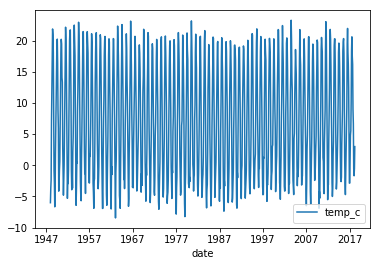

In [130]:
den.plot(x='date', y='temp_c')

In [125]:
den.tail()

,grid_id,glon,glat,date,temp_c
1286456,965,-105.0,40.0,2017-11-01,6.629158
1287990,965,-105.0,40.0,2017-12-01,-0.562914
1289524,965,-105.0,40.0,2018-01-01,-1.696782
1291058,965,-105.0,40.0,2018-02-01,-0.479477
1292592,965,-105.0,40.0,2018-03-01,2.982241


In [122]:
den.shape

(843, 5)

In [123]:
# print min and max date
print(temp_long_df['date'].min(), temp_long_df['date'].max())

1948-01-01 2018-03-01


Saving long monthly temperature for regrided US grid to csv.

In [128]:
# commented out to not write again
#temp_long_df.to_csv('../data/model_data/1948-2018_mon_temp_us.csv')

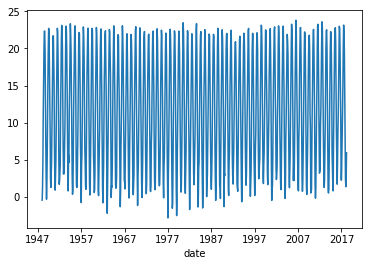

In [34]:
# mean US temperature grid time series
mean_temp = temp_long_df.groupby(['date'])['temp_c'].mean()
# mean plot
mean_temp.plot(x='date', y='temp_c')

In [39]:
temp_long_df.head()

,grid_id,lon,lat,date,temp_c
0,1,-125.0,27.5,1948-01-01,-0.177099
1,2,-124.0,27.5,1948-01-01,-1.932245
2,3,-123.0,27.5,1948-01-01,-3.540723
3,4,-122.0,27.5,1948-01-01,-4.988208
4,5,-121.0,27.5,1948-01-01,-6.260375


In [48]:
# convert to datetime
temp_long_df['date'] = pd.to_datetime(temp_long_df['date'])
# create year variable and plot average temperature by year
temp_long_df['year'] = temp_long_df['date'].dt.year
# group by year
mean_temp = temp_long_df.groupby(['year'])['temp_c'].mean().reset_index()
# filter out outliers
mean_temp = mean_temp[mean_temp['temp_c'] > 8]

In [46]:
mean_temp.head()

,year,temp_c
0,1948,11.633685
1,1949,11.930278
2,1950,11.601530
3,1951,11.483088
4,1952,12.242225


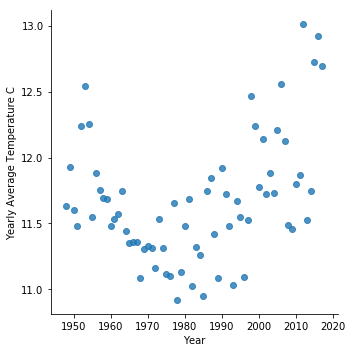

In [54]:
ax = sns.lmplot(x='year', y='temp_c', fit_reg= False, data = mean_temp)
ax.set(xlabel = 'Year', ylabel = 'Yearly Average Temperature C')